In [1]:
import poppy
import jax
import functools

[[1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]


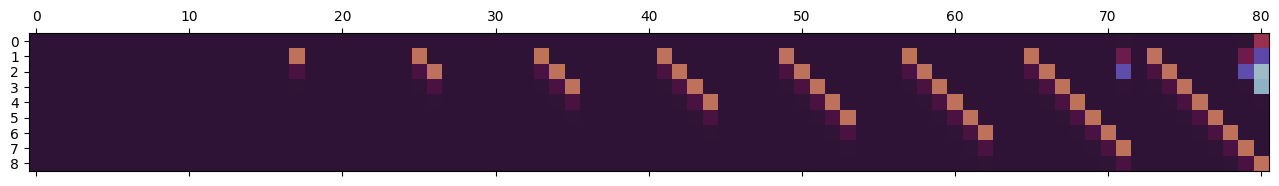

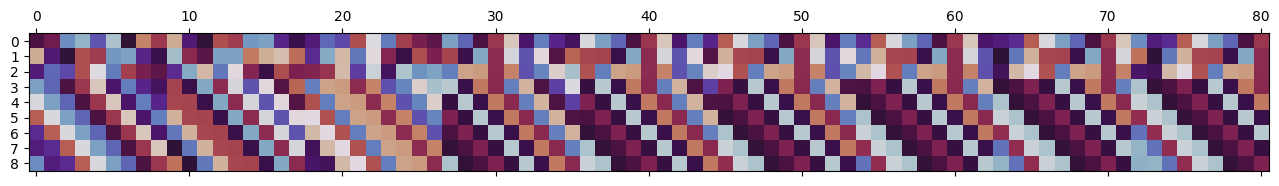

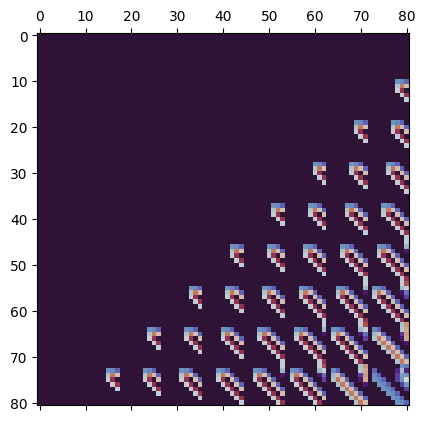

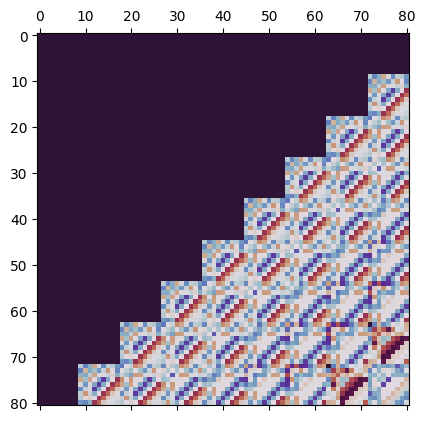

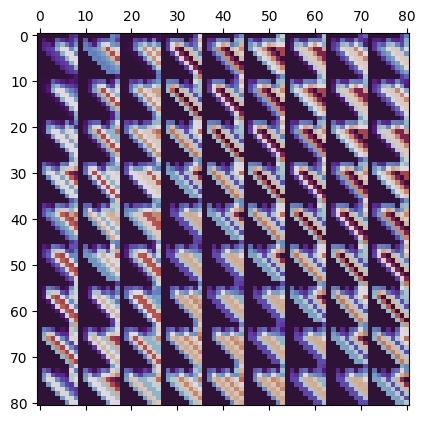

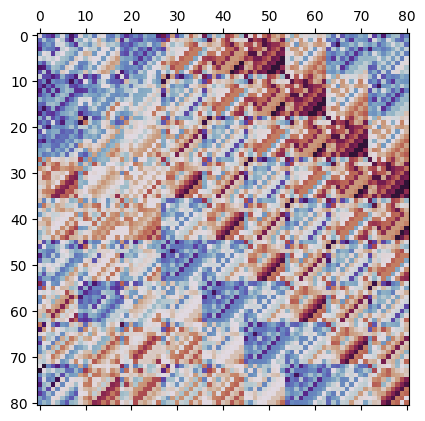

In [2]:
p = 3329
n = 9
f = poppy.field(p,n)

print(poppy.ptrace(jax.numpy.tensordot(f.BASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2),p))
poppy.plot(f.BASIS)
poppy.plot(f.DUALBASIS)
poppy.plot(jax.numpy.tensordot(f.BASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n)))
poppy.plot(jax.numpy.tensordot(f.BASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n)))
poppy.plot(jax.numpy.tensordot(f.DUALBASIS,f.BASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n)))
poppy.plot(jax.numpy.tensordot(f.DUALBASIS,f.DUALBASIS, axes = ([2],[1])).swapaxes(1,2).reshape((n*n,n*n)))


In [3]:
p = 3329
n = 4
f = poppy.field(p,n)
b = 64
k = 8

psd = 1230 # Public seed.
ssd = (908235,3209,4580,1,583981) # Secret seeds.

@functools.partial(jax.jit, static_argnums = 0)
def uniform(seed):
  sample = jax.random.randint(jax.random.key(seed), (b,k,k,n), 0,p, dtype = poppy.DTYPE)
  return sample

@functools.partial(jax.jit, static_argnums = 0)
def normal(seed):
  bits = jax.random.bits(jax.random.key(seed), shape = (b*k*k*n,1), dtype = jax.numpy.uint8)
  bitsream = jax.numpy.unpackbits(bits, axis = 1).reshape((b*k*k*n,2,4))
  sample = jax.numpy.sum(bitsream, axis = 2, dtype = poppy.DTYPE)
  return jax.numpy.subtract(sample[:,0],sample[:,1]).reshape((b,k,k,n))%p

@jax.jit
def base(a,b):
  return jax.numpy.tensordot(a,b, axes = ([-1],[0]))%p

@jax.jit
def dot(x,y):
  return jax.numpy.tensordot(x,y, axes = ([1,3],[0,2])).swapaxes(1,2)%p
mul = jax.vmap(dot)

@jax.jit
def keygen():
  pk1 = base(uniform(psd),f.BASIS)                # b k k n n public key
  sk = base(normal(ssd[0]),f.BASIS.swapaxes(1,2)) # b k k n n secret key
  e = base(normal(ssd[1]),f.DUALBASIS)            # b k k n n error
  pk2 = (mul(pk1,sk)+e)%p                         # b k k n n public key
  return pk1,sk,e,pk2

@jax.jit
def encrypt(message,pk2):
  pk1 = base(uniform(psd),f.BASIS)                    # b k k n n public key
  r = base(normal(ssd[2]),f.BASIS)                    # b k k n n randomness
  e1 = base(normal(ssd[3]),f.DUALBASIS.swapaxes(1,2)) # b k k n n error
  e2 = base(normal(ssd[4]),f.DUALBASIS)               # b k k n n error
  m = (p//2)*message.reshape((b,k,k,1,1))*f.DUALBASIS[0].reshape((1,1,1,n,n))%p # b k k n n message
  ct1 = (mul(pk1.swapaxes(1,2),r)+e1)%p               # b k k n n cipher text
  ct2 = (mul(pk2.swapaxes(1,2),r)+e2+m)%p             # b k k n n cipher text
  return r,e1,e2,m,ct1,ct2

@jax.jit
def decrypt(sk,ct1,ct2):
  w = mul(sk.swapaxes(1,2),ct1)
  d = 1-jax.numpy.astype(jax.numpy.abs(jax.numpy.rint(2/p*poppy.ptrace((ct2-w)%p,p)-1)), poppy.DTYPE).reshape((b,k,k))
  return w,d

bits = jax.random.bits(jax.random.key(0), shape = (b*k*k//8+1,), dtype = jax.numpy.uint8)
message = jax.numpy.astype(jax.numpy.unpackbits(bits)[:b*k*k].reshape((b,k,k)), poppy.DTYPE)

pk1,sk,e,pk2 = keygen()
r,e1,e2,m,ct1,ct2 = encrypt(message,pk2)
w,d = decrypt(sk,ct1,ct2)
print(poppy.ptrace(ct2,p).ravel())
print(message-d)
print(message)
print(d)


[2912  485   48 ... 2359  983 2441]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 1 0 ... 1 0 0]
  [0 0 1 ... 1 1 1]
  [1 1 0 ... 0 0 1]
  ...
  [0 0 0 ... 0 1 1]
  [1 1 1 ... 0 0 1]
  [1 0 0 ... 0 1 0]]

 [[1 0 0 ... 1 0 1]
  [1 1 1 ... 1 0 1]
  [0 1 0 ... 0 0 1]
  

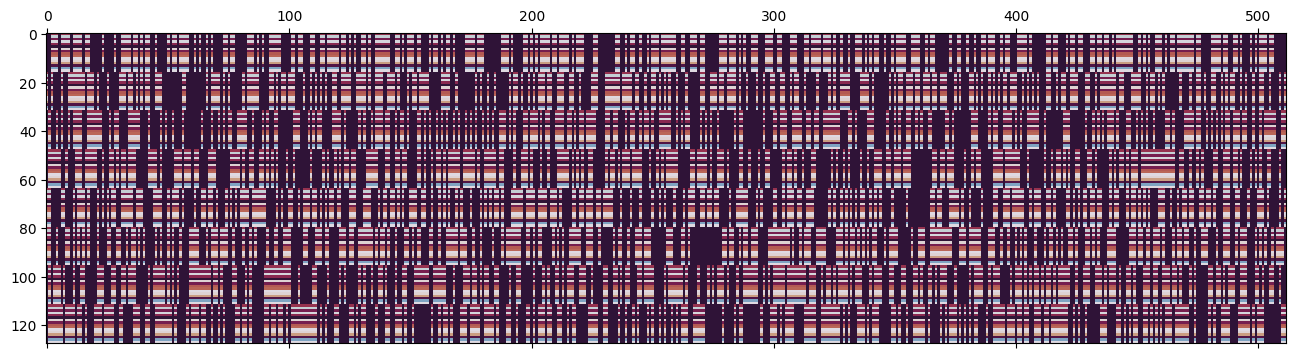

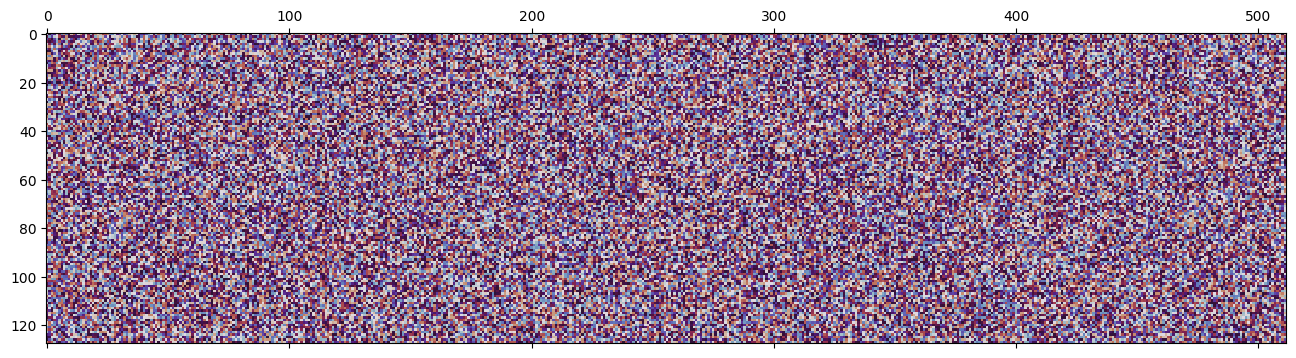

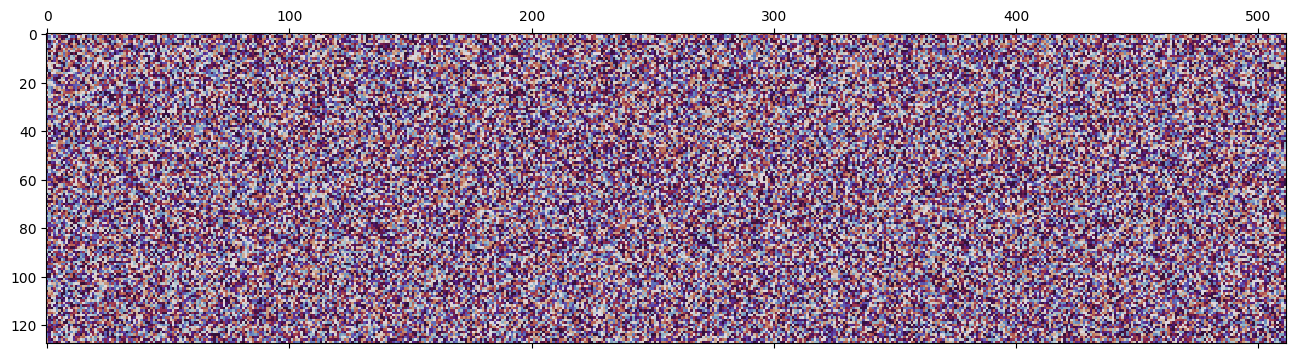

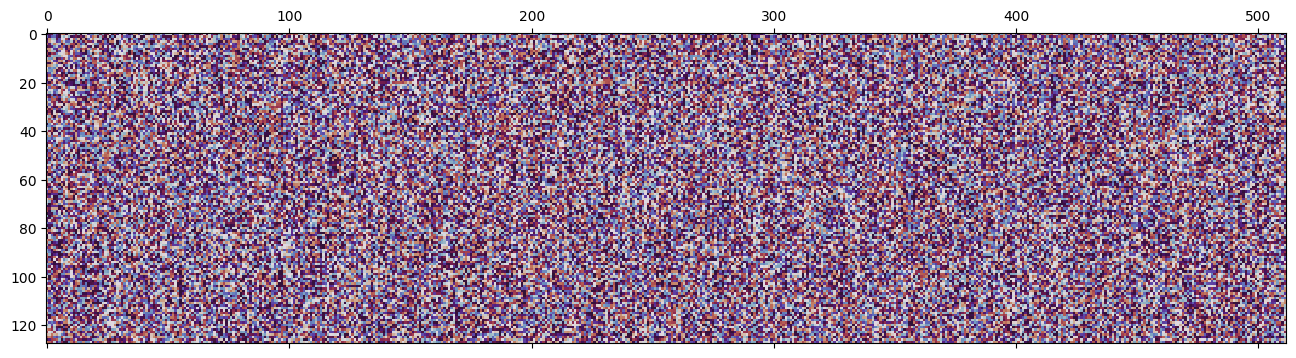

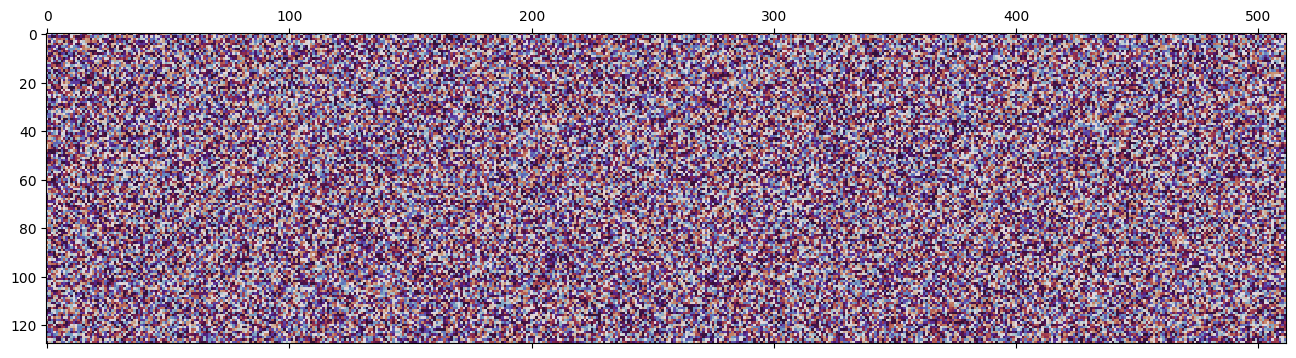

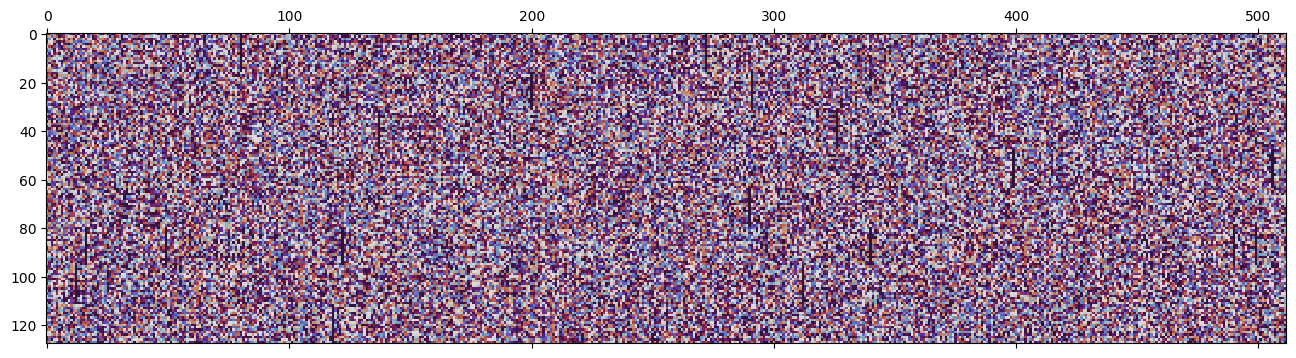

In [4]:
poppy.plot(m.reshape((b*k,-1)))
poppy.plot(ct1.reshape((b*k,-1)))
poppy.plot(ct2.reshape((b*k,-1)))
poppy.plot(pk1.reshape((b*k,-1)))
poppy.plot(pk2.reshape((b*k,-1)))
poppy.plot(e.reshape((b*k,-1)))